In [135]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [136]:
from mini_yolov3.model import MiniYOLOV3
from mini_yolov3.trainer import Trainer
import torch
from torchvision.transforms import v2
from mini_yolov3.dataset import SVHNDataset, collate_fn
from torch.utils.data import Subset, DataLoader
from mini_yolov3.loss import YOLOLoss, build_targets
import matplotlib.pyplot as plt
from mini_yolov3.utils import draw_bounding_boxes
from torchvision.ops import box_convert
from mini_yolov3.model_output import YoloV3Output

In [137]:
anchors = torch.Tensor([[0.2, 0.8]])

In [138]:
train_dataset = SVHNDataset(split="train", image_transform=v2.Compose([
                        v2.ToTensor(),
                        v2.Resize((32, 32))  
                      ]))
train_dataset = Subset(train_dataset, range(12, 13))

/Users/ericchen/Library/Caches/pypoetry/virtualenvs/mini-yolov3-a3VRlvzj-py3.10/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [139]:
train_dataset[0]["bbox"]

tensor([[0.3793, 0.0208, 0.2184, 0.8958]])

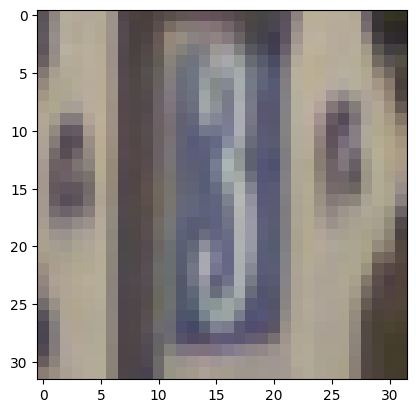

In [140]:
plt.imshow(train_dataset[0]["image"].permute(1, 2, 0))

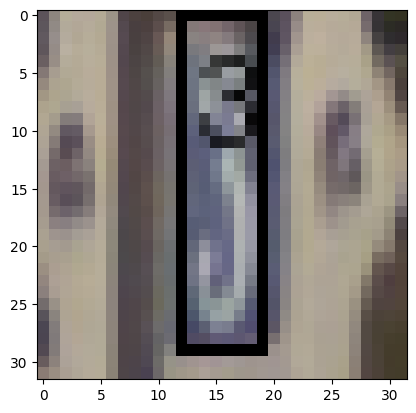

In [141]:
plt.imshow(
    draw_bounding_boxes(train_dataset[0]["image"], box_convert(train_dataset[0]["bbox"], "xywh", "xyxy"), train_dataset[0]["labels"])
)

In [142]:
dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, collate_fn=collate_fn)

In [143]:
for batch in dataloader:
    print(batch["bboxes"])
    targets = build_targets(batch["bboxes"], batch["labels"], (2, 2), anchors, 10)

[tensor([[0.3793, 0.0208, 0.2184, 0.8958]])]


In [183]:
torch.manual_seed(0)

model = MiniYOLOV3(
    image_size=32,
    num_classes=10,
    anchors=anchors
)
# model = MiniYOLOV3(
#     image_size=32,
#     num_classes=10,
#     anchors=anchors
# )

# model = torch.nn.Conv2d(3, 15, 2|, 2)

trainer = Trainer(
    model=model,
    train_dataset=train_dataset,
    num_epochs=250,
    # lr=3e-4,
    lr=3e-3,
    lambda_coord=5.0,
    lambda_noobj=0.5
)

In [184]:
trainer.train()

100%|██████████| 250/250 [00:01<00:00, 183.24it/s, loss=5.05e-11]


[0.24267199635505676,
 0.2449420541524887,
 0.2360110729932785,
 0.23184888064861298,
 0.22716569900512695,
 0.22024068236351013,
 0.21328088641166687,
 0.2076101452112198,
 0.20256748795509338,
 0.19683730602264404,
 0.19032762944698334,
 0.18383578956127167,
 0.17794759571552277,
 0.17250417172908783,
 0.16694621741771698,
 0.16105997562408447,
 0.15513980388641357,
 0.14955849945545197,
 0.14435148239135742,
 0.13922040164470673,
 0.133919820189476,
 0.12852589786052704,
 0.12329724431037903,
 0.11837060004472733,
 0.11364080011844635,
 0.10893076658248901,
 0.10421764850616455,
 0.09963575750589371,
 0.09529192000627518,
 0.09113720059394836,
 0.08704154193401337,
 0.082960344851017,
 0.07897605746984482,
 0.07518170028924942,
 0.07157107442617416,
 0.06806739419698715,
 0.06463497132062912,
 0.0613180547952652,
 0.05816734582185745,
 0.055166348814964294,
 0.052256226539611816,
 0.049415428191423416,
 0.04668040573596954,
 0.044087644666433334,
 0.04162523150444031,
 0.03925742208

In [280]:
pred = model(batch["images"].to("mps"))
pred.shape

torch.Size([1, 15, 2, 2])

In [281]:
pred[0, :, 0, 0]

tensor([ 3.3309e+00,  2.5957e+00,  9.1555e-02,  1.4053e-01,  1.0250e+00,
         2.8872e-03, -5.9916e-02,  3.5278e-03,  1.0026e+00, -5.5062e-03,
         4.8427e-03, -7.9594e-03,  7.0756e-03, -2.6215e-02,  5.1524e-03],
       device='mps:0', grad_fn=<SelectBackward0>)

In [282]:
targets[0, :, 0, 0]

tensor([3.7495, 2.7081, 0.0880, 0.1131, 1.0000, 0.0000, 0.0000, 0.0000, 1.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000])

In [283]:
output = YoloV3Output(pred, model.anchors, 10)

In [284]:
bounding_boxes = output.bounding_boxes()

In [285]:
bounding_boxes

[{'bboxes': tensor([[0.3731, 0.0049, 0.2192, 0.9207]], device='mps:0',
         grad_fn=<StackBackward0>),
  'confidence': tensor([1.0250], device='mps:0', grad_fn=<SelectBackward0>),
  'labels': tensor([3], device='mps:0')}]

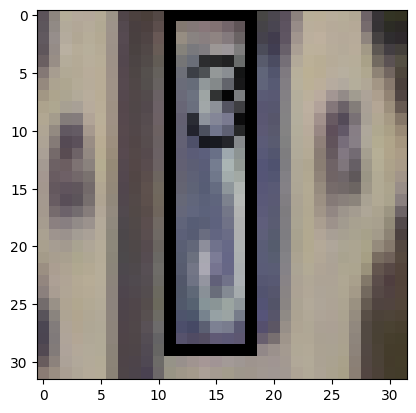

In [286]:
plt.imshow(
    draw_bounding_boxes(batch["images"][0],
                        box_convert(
                            bounding_boxes[0]["bboxes"], 
                            "xywh",
                            "xyxy"
                        ), 
                        bounding_boxes[0]["labels"])
)